# Superconductivity with KWANT

### © Jalil Varela-Manjarres, University of Delaware
[PHYS824: Nanophysics & Nanotechnology](https://wiki.physics.udel.edu/phys824) 

Some of the following examples were taken and adapted from https://tkwant.kwant-project.org/doc/dev/tutorial

## What is covered in this notebook
 

 Physics background

 - Conductance of a NS-junction (Andreev reflection, superconducting gap)

-  1D SNS-juntion with and without Barrier


-  2D SAS-juntion with A being and altermagnetic d-metal (Pending)

In [1]:
import kwant
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tinyarray
import numpy as np
tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])

The corresponding
tight–binding Hamiltonian is
\begin{equation}
\hat H =
\sum_{i=-\infty}^{+\infty}\sum_{\sigma=\uparrow,\downarrow}
\left[
e^{-i\varphi_J(t)\delta_{i,-1}}
\hat c_{i\sigma}^\dagger \hat c_{i+1,\sigma}
+
\left(U\delta_{i,0}-E_F\right)
\hat c_{i\sigma}^\dagger \hat c_{i\sigma}
\right]
+
\sum_{i=-\infty}^{+\infty}
\left[
\Delta (1-\delta_{i,0})\,\hat c_{i\uparrow}^\dagger \hat c_{i\downarrow}^\dagger
+ \text{h.c.}
\right].
\label{eq:H_SNS}
\end{equation}
Here $\hat c_{i,\sigma}^\dagger$ ($\hat c_{i,\sigma}$) creates (annihilates)
a fermion with spin $\sigma\in\{\uparrow,\downarrow\}$ on site $i$.
The time–dependent phase
\begin{equation}
\varphi_J(t) = \frac{e}{\hbar} \int_0^t V_J(t')\,\mathrm{d}t'
\end{equation}
is determined by the voltage drop $V_J(t)$ across the junction, which we
assume to be located between the left superconducting lead and the central
site. The parameter $\Delta$ denotes the superconducting gap inside the
leads, $U$ is a local barrier potential controlling the normal-state
transmission probability $D$ of the junction, and $E_F$ is the Fermi
energy. Within T-Kwant this Hamiltonian is treated almost as a standard
normal-state tight-binding model; superconductivity simply doubles the
local Hilbert space by introducing electron and hole degrees of freedom on
each site.



To make the notation more compact we introduce single-particle matrix
elements
\begin{equation}
h_{ij} = e^{-i\varphi_J(t)\delta_{i,-1}} \delta_{i,j+1}
       + (U\delta_{i,0}-E_F)\delta_{ij},
\qquad
\Delta_{ij} = \Delta (1-\delta_{i,0}) \delta_{ij}.
\label{eq:hij_Dij}
\end{equation}
Strictly speaking, these expressions specify only the upper-triangular part
of the Hamiltonian matrix; the lower-triangular part follows from Hermitian
conjugation. With this definition the second-quantized Hamiltonian becomes
\begin{equation}
\hat H =
\sum_{i,j=-\infty}^{+\infty}
\left[
h_{ij}\bigl(
\hat c_{i\uparrow}^\dagger \hat c_{j\uparrow}
+
\hat c_{i\downarrow}^\dagger \hat c_{j\downarrow}
\bigr)
+
\Delta_{ij}\hat c_{i\uparrow}^\dagger \hat c_{j\downarrow}^\dagger
+
\Delta_{ij}^\ast \hat c_{i\downarrow}\hat c_{j\uparrow}
\right].
\label{eq:H_hDelta}
\end{equation}

Using the fermionic anticommutation relations one can show that
\begin{equation}
h_{ij}\,\hat c_i^\dagger \hat c_j
= \frac{1}{2}
\left(
h_{ij}\,\hat c_i^\dagger \hat c_j
- h_{ji}^\ast\,\hat c_j \hat c_i^\dagger
+ h_{ii}\,\delta_{ij}
\right),
\label{eq:fermion_identity}
\end{equation}
which allows us to cast the Hamiltonian in Bogoliubov–de Gennes (BdG)
matrix form,
\begin{equation}
\hat H =
\sum_{i,j=-\infty}^{+\infty}
\bigl(\hat c_{i\uparrow}^\dagger,\,
      \hat c_{i\downarrow}\bigr)
\,H_{ij}\,
\begin{pmatrix}
\hat c_{j\uparrow}\\[2pt]
\hat c_{j\downarrow}^\dagger
\end{pmatrix},
\label{eq:H_BdG_matrix}
\end{equation}
where $H_{ij}$ is the $2\times2$ BdG Hamiltonian in Nambu (electron–hole)
space.



## Example 1:"Superconductors": orbitals, conservation laws and symmetries


This example deals with superconductivity on the level of the Bogoliubov-de Gennes (BdG) equation. In this framework, the Hamiltonian is given as

  $$ H = \begin{pmatrix}
            H_0 - \mu      & \Delta \\
            \Delta^\dagger & \mu - \mathcal{T} H_0 \mathcal{T}^{-1}
        \end{pmatrix}$$

where $H_0$ is the Hamiltonian of the system without
superconductivity, $\mu$ the chemical potential, $\Delta$
the superconducting order parameter, and $\mathcal{T}$
the time-reversal operator. The BdG Hamiltonian introduces
electron and hole degrees of freedom (an artificial doubling -
be aware of the fact that electron and hole excitations
are related!), which we will need to include in our model with Kwant.

For this we restrict ourselves to a simple spinless system without
magnetic field, so that $\Delta$ is just a number (which we
choose real), and $\mathcal{T}H_0\mathcal{T}^{-1}=H_0^*=H_0.$
Furthermore, note that the Hamiltonian has particle-hole symmetry
$\mathcal{P}$, i. e. $\mathcal{P}H\mathcal{P}^{-1}=-H.$



### N-S Junction 

Let us consider a system that consists of a normal lead on the left,
a superconductor on the right, and a tunnel barrier in between:

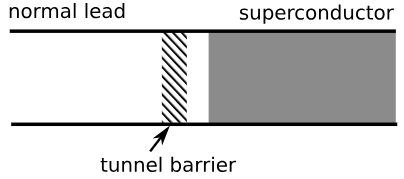


Care must be taken when transport calculations are done with
the BdG equation. Electrons and holes carry charge with
opposite sign, such that it is necessary to separate the electron
and hole degrees of freedom in the scattering matrix.
In particular, the conductance of a N-S-junction is given as


 $$ G = \frac{e^2}{h} (N - R_\text{ee} + R_\text{he})\,,$$

We implement the BdG Hamiltonian in Kwant using a 2x2 matrix structure
for all Hamiltonian matrix elements.
We start by declaring some parameters that will be used in the following code:


In [2]:
a = 1
W, L = 10, 10
barrier = 0.0
barrierpos = (3, 4)
mu = 0.4
Delta = 0.1
Deltapos = 4
t = 1.0
sep=4*t-mu

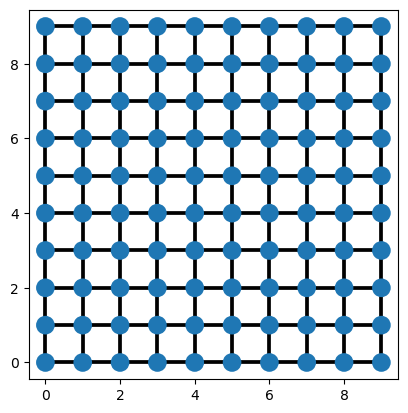

In [4]:
# Start with an empty tight-binding system. On each site, there
# are now electron and hole orbitals, so we must specify the
# number of orbitals per site. The orbital structure is the same
# as in the Hamiltonian.
lat = kwant.lattice.square(norbs=2)
syst = kwant.Builder()

#### Define the scattering region. ####
# The superconducting order parameter couples electron and hole orbitals
# on each site, and hence enters as an onsite potential.
# The pairing is only included beyond the point 'Deltapos' in the scattering region.
syst[(lat(x, y) for x in range(Deltapos) for y in range(W))] = (4 * t - mu) * tau_z
syst[(lat(x, y) for x in range(Deltapos, L) for y in range(W))] = (4 * t - mu) * tau_z + Delta * tau_x

# The tunnel barrier
syst[(lat(x, y) for x in range(barrierpos[0], barrierpos[1])
     for y in range(W))] = (4 * t + barrier - mu) * tau_z

# Hoppings
syst[lat.neighbors()] = -t * tau_z

kwant.plot(syst)
plt.show()

Note the argument ``norbs`` to `~kwant.lattice.square`. This is
the number of orbitals per site in the discretized BdG Hamiltonian - of course,
``norbs = 2``, since each site has one electron orbital and one hole orbital.
It is necessary to specify ``norbs`` here, such that we may later separate the
scattering matrix into electrons and holes. Aside from this, creating the system
is syntactically equivalent to :ref:`spin example <tutorial_spinorbit>`.
The only difference is that the Pauli matrices now act in electron-hole space.
Note that the tunnel barrier is added by overwriting previously set
on-site matrix elements.

The superconducting order parameter is nonzero only in a part of the
scattering region - the part to the right of the tunnel barrier. Thus,
the scattering region is split into a superconducting part (the right
side of it), and a normal part where the pairing is zero (the left side
of it). The next step towards computing conductance is to attach leads.
Let's attach two leads: a normal one to the left end, and a superconducting
one to the right end. Starting with the left lead, we have:


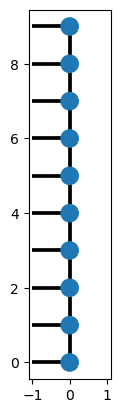

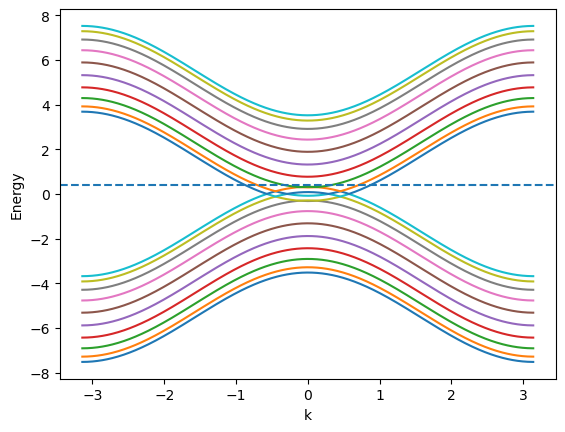

In [5]:
#### Define the leads. ####
# Left lead - normal, so the order parameter is zero.
sym_left = kwant.TranslationalSymmetry((-a, 0))
# Specify the conservation law used to treat electrons and holes separately.
# We only do this in the left lead, where the pairing is zero.
lead0 = kwant.Builder(sym_left, conservation_law=-tau_z)#, particle_hole=tau_y)
lead0[(lat(0, j) for j in range(W))] = (4 * t - mu) * tau_z
lead0[lat.neighbors()] = -t * tau_z


kwant.plot(lead0)
plt.show()


k = np.arange(-np.pi, np.pi, 0.01)
fig = kwant.plotter.bands(lead0.finalized(), momenta=k, show=False);
ax = fig.axes[0]
#ax.set_ylim(-2.0, 2.0);
ax.axhline(0.4,ls="--")

Note the two new new arguments in `~kwant.builder.Builder`, ``conservation_law``
and ``particle_hole``. For the purpose of computing conductance, ``conservation_law``
is the essential one, as it allows us to separate the electron and hole degrees of
freedom. Note that it is not necessary to specify ``particle_hole``
in `~kwant.builder.Builder` to correctly compute the conductance in this example.
We will discuss the argument ``particle_hole`` later on. First, let us
discuss ``conservation_law`` in more detail.

Observe that electrons and holes are uncoupled in the left (normal) lead, since
the superconducting order parameter that couples them is zero.
Consequently, we may view the electron and hole degrees of freedom as being
conserved, and may therefore separate them in the Hamiltonian.

In more technical terms, the conservation law implies that the Hamiltonian
can be block diagonalized into uncoupled electron and hole blocks. Since
the blocks are uncoupled, we can construct scattering states in each block
independently. Of course, any scattering state from the electron (hole) block
is entirely electron (hole) like. As a result, the scattering matrix separates
into blocks that describe the scattering between different types of carriers,
such as electron to electron, hole to electron, et cetera.

As we saw above, conservation laws in Kwant are specified with the
``conservation_law`` argument in `~kwant.builder.Builder`.
Specifically, ``conservation_law`` is a matrix that acts on a single *site*
and it must in addition have integer eigenvalues.
Of course, it must also commute with the onsite Hamiltonian and hoppings
to adjacent sites. Internally, Kwant then uses the eigenvectors of the
conservation law to block diagonalize the Hamiltonian. Here, we've specified
the conservation law $-\sigma_z$, such that the eigenvectors with
eigenvalues $-1$ and $1$ pick out the electron and hole
blocks, respectively. Internally in Kwant, the blocks are stored in the order
of ascending eigenvalues of the conservation law.

In order to move on with the conductance calculation, let's attach the second
lead to the right side of the scattering region:

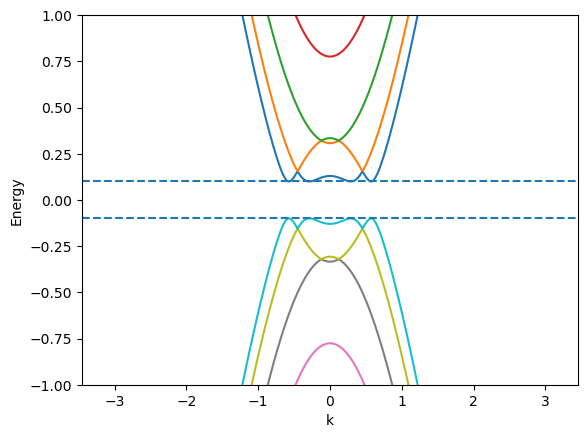

In [6]:
# Right lead - superconducting, so the order parameter is included.
sym_right = kwant.TranslationalSymmetry((a, 0))
lead1 = kwant.Builder(sym_right)
lead1[(lat(0, j) for j in range(W))] = (4 * t - mu) * tau_z + Delta * tau_x
lead1[lat.neighbors()] = -t * tau_z


k = np.arange(-np.pi, np.pi, 0.01)
fig = kwant.plotter.bands(lead1.finalized(), momenta=k, show=False);
ax = fig.axes[0]
ax.set_ylim(-1.0, 1.0);

#ax.axhline(0.0,ls="--")
ax.axhline(0.1,ls="--")
ax.axhline(-0.1,ls="--")



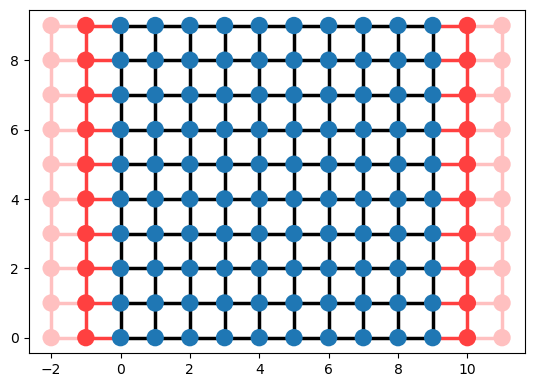

In [7]:
#### Attach the leads and finalize the system. ####
syst.attach_lead(lead0)
syst.attach_lead(lead1)

syst = syst.finalized()

#plt.figure()
kwant.plot(syst)
plt.show()

The second (right) lead is superconducting, such that the electron and hole
blocks are coupled. Of course, this means that we can not separate them into
uncoupled blocks as we did before, and therefore no conservation law is specified.

Kwant is now aware of the block structure of the Hamiltonian in the left lead.
This means that we can extract transmission and reflection amplitudes not only
into the left lead, but also between different conservation law blocks in
the left lead. Generally if leads :math:`i` and :math:`j` both have a conservation
law specified, ``smatrix.transmission((i, a), (j, b))`` gives us
the scattering probability of carriers from block :math:`b` of lead :math:`j`, to
block :math:`a` of lead :math:`i`. In our example, reflection from electrons to
electrons in the left lead is thus ``smatrix.transmission((0, 0), (0, 0))`` (Don't get
confused by the fact that it says ``transmission`` -- transmission
into the same lead is reflection), and reflection from electrons to holes
is ``smatrix.transmission((0, 1), (0, 0))``:

In [8]:
def plot_conductance(syst, energies):
    # Compute conductance
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        # Conductance is N - R_ee + R_he
        data.append(smatrix.submatrix((0, 0), (0, 0)).shape[0] -
                    smatrix.transmission((0, 0), (0, 0)) +
                    smatrix.transmission((0, 1), (0, 0)))
    pyplot.figure()
    pyplot.plot(energies, data)
    pyplot.xlabel("energy [t]")
    pyplot.ylabel("conductance [e^2/h]")
    plt.axvline(0.1,ls="--")
    
    pyplot.show()
    

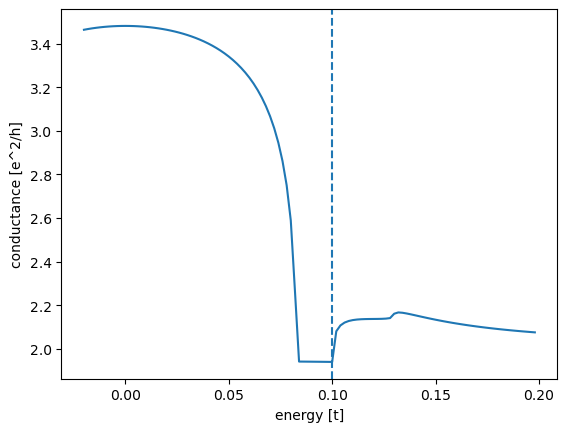

In [9]:
plot_conductance(syst, energies=[0.002 * i for i in range(-10, 100)])

In [13]:
def plot_reflection(syst, energies):
    # Compute conductance
    data_refle_ee = []
    data_refle_hh = []
    data_refle_eh = []

    
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        # Conductance is N - R_ee + R_he
        data_refle_ee.append(smatrix.transmission((0, 0), (0, 0)) )
#        data_refle_hh.append(smatrix.transmission((0, 1), (0, 1)) )
        data_refle_eh.append(smatrix.transmission((0, 0), (0, 1)) )
        
#         data_trans_ee.append(smatrix.transmission((0, 0), (1, 0)) )
#         data_trans_hh.append(smatrix.transmission((0, 1), (1, 1)) )
#         data_trans_eh.append(smatrix.transmission((0, 0), (1, 1)) )
       
    pyplot.figure()
    pyplot.plot(energies, data_refle_ee,label=r"R_ee")
    #pyplot.plot(energies, data_refle_hh,label=r"R_hh")
    pyplot.plot(energies, data_refle_eh,label=r"R_he")
    pyplot.xlabel("energy [t]")
    pyplot.ylabel("Reflection")
    pyplot.legend()
    pyplot.show()
    
    
def plot_transmission(syst, energies):
    # Compute conductance
    data_trans_ee = []
    data_trans_hh = []
    data_trans_eh = []

    
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        # Conductance is N - R_ee + R_he
#         data_refle_ee.append(smatrix.transmission((0, 0), (0, 0)) )
#         data_refle_hh.append(smatrix.transmission((0, 1), (0, 1)) )
#         data_refle_eh.append(smatrix.transmission((0, 0), (0, 1)) )
        
        data_trans_ee.append(smatrix.transmission((1, 0), (0, 0)) )
        #data_trans_hh.append(smatrix.transmission((1, 1), (0, 1)) )
        data_trans_eh.append(smatrix.transmission((1, 0), (0, 1)) )
       
    pyplot.figure()
    pyplot.plot(energies, data_trans_ee,label=r"T_ee")
    #pyplot.plot(energies, data_refle_hh,label=r"R_hh")
    pyplot.plot(energies, data_trans_eh,label=r"T_eh")
    pyplot.xlabel("energy [t]")
    pyplot.ylabel("Trasmission")
    pyplot.legend()
    pyplot.show()
    


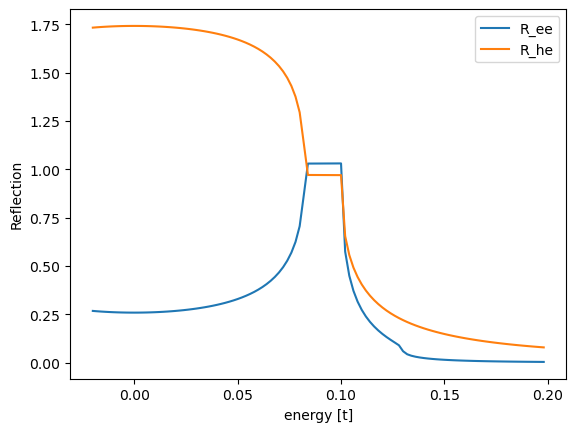

In [14]:
plot_reflection(syst, energies=[0.002 * i for i in range(-10, 100)])

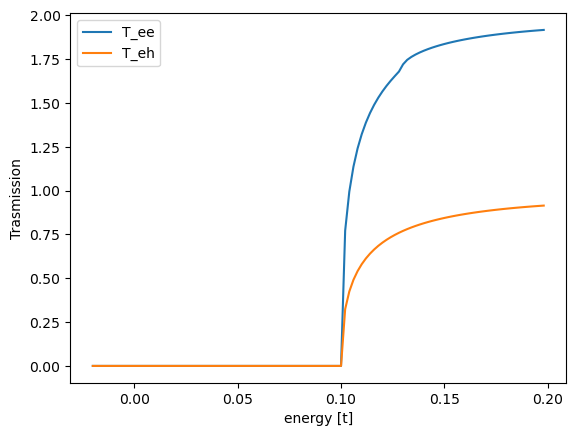

In [15]:
plot_transmission(syst, energies=[0.002 * i for i in range(-10, 100)])

## S-N-S Junction in 1D system 

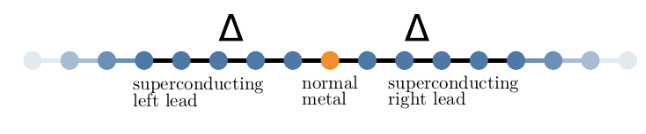


We consider a short, ballistic S--N--S junction with a single perfectly
transmitting channel ($T = 1$). The left and right superconducting
electrodes have the same gap $\Delta$ but different phases, $-\phi/2$
and $+\phi/2$, respectively. We focus on subgap energies $|E| < \Delta$.

For energies inside the gap, quasiparticles cannot propagate in the bulk
of the superconductors and are instead Andreev reflected at the
interfaces. An incident electron from the normal region is retroreflected
as a hole with the Andreev reflection amplitude
$
r_A(E) = e^{-i \arccos(E/\Delta)}.
$
At the opposite interface, the hole is converted back into an electron
with the same magnitude of phase shift.

 We neglect 
(i) normal reflection at the interfaces and 
(ii) the dynamical phase accumulated in the normal region (its length is
much shorter than the superconducting coherence length). A closed
electron--hole orbit inside the junction then consists of:


- two Andreev reflections, one at each S/N interface, giving a total
        Andreev phase $2 \arccos(E/\Delta)$;
- the superconducting phase difference $\phi$ picked up between the
        two electrodes.


The quantization condition for an Andreev bound state is that the total
phase acquired by an electron--hole loop is an integer multiple of $2\pi$:
$
2 \arccos(E/\Delta) + \phi = 2\pi n, \qquad n \in \mathbb{Z}.
$
Solving for $E$,

$$
\arccos(E/\Delta) = \pi n - \frac{\phi}{2}
\;\Rightarrow\;
\frac{E}{\Delta} = \cos\!\Bigl(\pi n - \frac{\phi}{2}\Bigr)
                 = (-1)^n \cos\!\frac{\phi}{2}.
$$

Even and odd $n$ simply correspond to the two branches of the spectrum,
so we can write the Andreev bound state energies as
$$
E_\pm(\phi) = \pm \Delta \cos\frac{\phi}{2}.
$$

This is the dispersion of Andreev bound states in a short,
perfectly transmitting Josephson junction


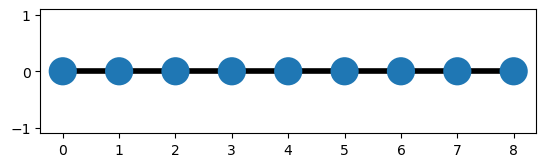

In [16]:
lat1d = kwant.lattice.chain(norbs=2)

def make_sns_1d(phi,
                LS=4,   # SC Left
                LW=1,   # Central region
                RS=4,   # SC Right
                mu=0.0, Delta=0.1, t=1.0):
    """
    SNS 1D finito (sin leads):
    - onsite normal: -mu * tau_z
    - hopping: -t * tau_z
    - SC izquierda: Delta * e^{-i phi/2}
    - SC derecha:   Delta * e^{+i phi/2}
    """
    syst = kwant.Builder()

    Ltot = LS + LW + RS

    for x in range(Ltot):
        # S1: x < LS
        if x < LS:
            Δ = Delta * np.exp(-0.5j * phi)
            onsite = -mu * tau_z + (Δ.real * tau_x - Δ.imag * tau_y)
        # N: LS <= x < LS+LW
        elif LS <= x < LS + LW:
            onsite = -mu * tau_z
        # S2: x >= LS+LW
        else:
            Δ = Delta * np.exp(+0.5j * phi)
            onsite = -mu * tau_z + (Δ.real * tau_x - Δ.imag * tau_y)

        syst[lat1d(x)] = onsite

    # Hoppings 1D (vecinos a distancia 1)
    syst[lat1d.neighbors()] = -t * tau_z

    return syst.finalized()

syst_test = make_sns_1d(0.0)
kwant.plot(syst_test)
plt.show()

make_sns_1d(0.0)

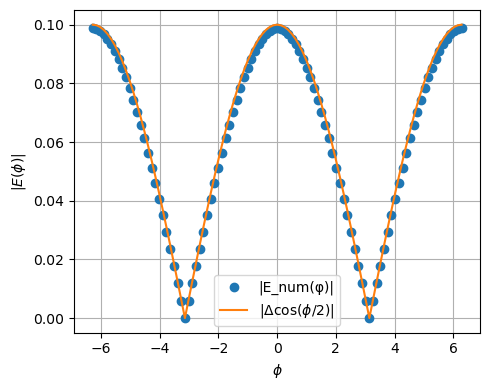

In [17]:
import scipy.sparse.linalg as sla

Delta = 0.1
t = 1.0
mu = 0.0
LS, LW, RS = 100, 1, 100

phi_list = np.linspace(-2*np.pi, 2*np.pi, 101)
E_num = np.full_like(phi_list, np.nan, dtype=float)

k_eigs = 12   # nº de autovalores alrededor de 0

for i, phi in enumerate(phi_list):
    syst_f = make_sns_1d(phi, LS=LS, LW=LW, RS=RS,
                         mu=mu, Delta=Delta, t=t)

    H = syst_f.hamiltonian_submatrix(sparse=True)
    evals, evecs = sla.eigsh(H, k=k_eigs, sigma=0.0)
    evals = np.real(evals)

    # ordenamos por |E| y tomamos el más cercano a 0
    evals_sorted = sorted(evals, key=lambda E: abs(E))
    E_closest = evals_sorted[0]

    E_num[i] = abs(E_closest)

E_analytic_abs = np.abs(Delta * np.cos(phi_list / 2.0))

plt.figure(figsize=(5,4))
plt.plot(phi_list, E_num, 'o', label='|E_num(φ)|')
plt.plot(phi_list, E_analytic_abs, '-', label=r'$|\Delta \cos(\phi/2)|$')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$|E(\phi)|$')
##plt.title('SNS 1D corto: ABS numérico vs analítico')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Phase dependent current


In a Josephson junction the current is the rate of change of the number
of Cooper pairs, $I = 2e\, d\langle N\rangle/dt$, while the phase
difference $\phi$ is the variable conjugate to $N$. In a Josephson system, the phase $\phi$ is
canonically conjugate to the number of transferred pairs, which is
encoded in the commutation relation
$$
[\hat \phi, \hat N_R] = 2i,
$$
(up to conventions for factors of 2). This implies that the dependence
of the Hamiltonian on $\phi$ is equivalent to coupling to the number
operator. One can then rewrite the commutator as a derivative with
respect to $\phi$:
$$
[\hat H(\phi), \hat N_R]
= -\,2i\,\frac{\partial \hat H(\phi)}{\partial \phi}.
$$
Combining this with the Heisenberg equation gives
$$
\hat I = 2e\,\frac{d\hat N}{dt}
      = -\frac{2e}{\hbar}\frac{\partial \hat H}{\partial \phi},
$$
so that for an eigenstate with energy $E(\phi)$ one obtains
$$
I(\phi) = -\frac{2e}{\hbar}\frac{\partial E(\phi)}{\partial \phi}.
$$
Experimentally, the AC Josephson relation $d\phi/dt = 2eV/\hbar$
confirms this conjugate nature of phase and particle number:
a DC voltage $V$ makes the phase wind linearly in time, and the
resulting time-dependent current $I(\phi(t))$ is the measurable
signature of the transfer of Cooper pairs.

In thermal equilibrium, the supercurrent in a short Josephson junction
can be expressed in terms of the phase-dependent Andreev bound state (ABS)
energies $E_n(\phi)$ as
$$
I(\phi) = -\frac{2e}{\hbar}\sum_n
\frac{\partial E_n(\phi)}{\partial \phi}\, f\!\bigl(E_n(\phi)\bigr),
$$
where $f(E)$ is the Fermi-Dirac distribution and the factor $2e$ reflects
the charge of a Cooper pair.

For a single perfectly transparent channel ($T=1$) in a short junction,
the ABS spectrum is
$$
E_\pm(\phi) = \pm \Delta \cos\frac{\phi}{2}.
$$
At zero temperature, only the lower branch $E_-(\phi)$ is occupied
($f(E_-) = 1$, $f(E_+) = 0$). The current is then entirely carried by this
state:
$$
I(\phi) = -\frac{2e}{\hbar}\,\frac{\partial E_-(\phi)}{\partial \phi}
        = -\frac{2e}{\hbar}\,\frac{\partial}{\partial \phi}
          \bigl[-\Delta \cos(\phi/2)\bigr].
$$
Taking the derivative, we obtain
$$
I(\phi) = \frac{e\Delta}{\hbar}\,\sin\frac{\phi}{2}.
$$

This expression is valid for the short-junction limit
and for the phase interval where the branch $E_-(\phi)$ is the
ground state (typically $0 < \phi < \pi$). More generally, one
must account for the $2\pi$-periodicity and the possibility of
level crossings, which leads to a current-phase relation with
a cusp at $\phi = \pi$.

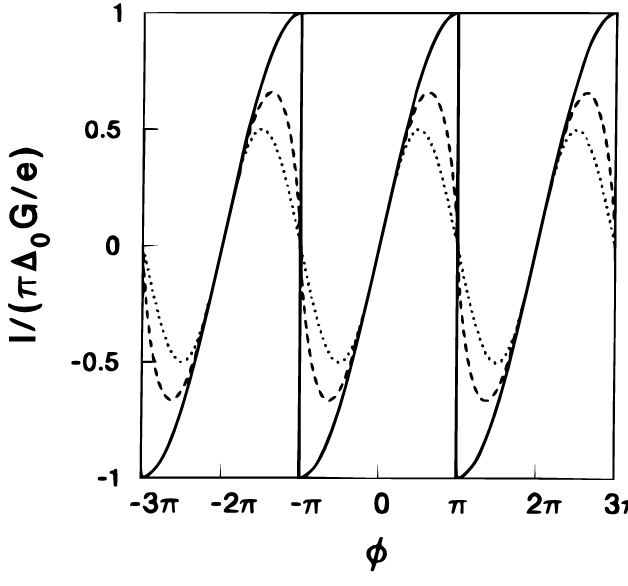

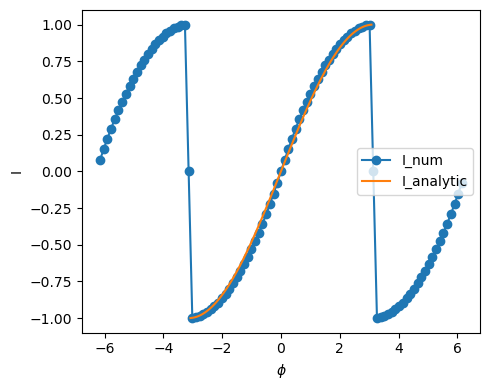

In [18]:
#phi_list = np.linspace(, 2*np.pi, 101)

I_num = np.full_like(phi_list, np.nan, dtype=float)
dphi = phi_list[1] - phi_list[0]

for i in range(1, len(phi_list)-1):
    if np.isfinite(E_num[i-1]) and np.isfinite(E_num[i+1]):
        I_num[i] = (E_num[i+1] - E_num[i-1]) / (2*dphi)


phi_list_n = np.linspace(-np.pi, np.pi, 101)
I_analytic = -(Delta / 2.0) * np.sin(phi_list_n / 2.0)

mask = np.isfinite(I_num)
phi_mask = phi_list[mask]
phin_mask = phi_list_n[mask]
I_num_norm = I_num[mask] / np.nanmax(np.abs(I_num[mask]))
I_an_norm  = I_analytic[mask] / np.max(np.abs(I_analytic[mask]))

plt.figure(figsize=(5,4))
plt.plot(phi_mask, -I_num_norm, 'o-', label='I_num')
plt.plot(phin_mask, -I_an_norm, '-', label='I_analytic')
plt.xlabel(r'$\phi$')
plt.ylabel('I')
##plt.title('Forma de I(φ) ~ dE/dφ: numérico vs analítico')
##plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
# ---------- Normal chain (spinless) para T ----------
lat_n = kwant.lattice.chain(norbs=2)
def make_normal_barrier_1d(Vb, L=1, mu=0.0, t=1.0):
    """
    Inifite Chain with a barrier Vb of one site in the central region
    """
    syst = kwant.Builder()
    # Región de scattering: L sitios, barrera en el centro
    for x in range(L):
        onsite = -mu
        if x == L // 2:
            onsite += Vb
        syst[lat_n(x)] = onsite

    syst[lat_n.neighbors()] = -t

    # Lead izquierdo
    sym_left = kwant.TranslationalSymmetry([-1])
    leadL = kwant.Builder(sym_left)
    leadL[lat_n(0)] = -mu
    leadL[lat_n.neighbors()] = -t

    # Lead derecho
    sym_right = kwant.TranslationalSymmetry([+1])
    leadR = kwant.Builder(sym_right)
    leadR[lat_n(0)] = -mu
    leadR[lat_n.neighbors()] = -t

    syst.attach_lead(leadL)
    syst.attach_lead(leadR)

    return syst.finalized()


def transm(Vb, mu=0.0, t=1.0, L=1, E=0.0):
    """
    Transmission with a barrier Vb.
    """
    systN = make_normal_barrier_1d(Vb, L=L, mu=mu, t=t)
    sm = kwant.smatrix(systN, energy=E)
    T = sm.transmission(1, 0)   # lead 0 -> lead 1
    return T


In [22]:
# ---------- BdG: SNS 1D corta con barrera Vb en la parte N ----------


lat1d = kwant.lattice.chain(norbs=2)

def make_sns_1d(phi,
                LS=4,   # longitud SC izquierda
                LW=1,   # longitud N (1 sitio)
                RS=4,   # longitud SC derecha
                mu=0.0, Delta=0.1, t=1.0,
                Vb=0.0):
    """
    SNS 1D finita (sin leads):
    - SC izquierda: Δ e^{-i φ/2}
    - N central: -mu τ_z + Vb τ_z
    - SC derecha: Δ e^{+i φ/2}
    """
    syst = kwant.Builder()
    Ltot = LS + LW + RS
    for x in range(Ltot):
        # S1: x < LS
        if x < LS:
            Δ = Delta * np.exp(-0.5j * phi)
            onsite = -mu * tau_z + (Δ.real * tau_x - Δ.imag * tau_y)
        # N (weak link, 1D, con barrera Vb)
        elif LS <= x < LS + LW:
            onsite = -mu * tau_z + Vb * tau_z
        # S2: x >= LS+LW
        else:
            Δ = Delta * np.exp(+0.5j * phi)
            onsite = -mu * tau_z + (Δ.real * tau_x - Δ.imag * tau_y)
        syst[lat1d(x)] = onsite
    # hoppings 1D
    syst[lat1d.neighbors()] = -t * tau_z

    return syst.finalized()


### Generalization when a weak barrier is included

Consider a short, single-channel S–N–S junction with normal-state
transmission probability $T$ (and reflection $R = 1 - T$). In the
superconducting leads we assume a real, energy-independent gap $\Delta$ and
phases $\pm \phi/2$ on the left and right superconductors.


For subgap energies $|E| < \Delta$, quasiparticles cannot propagate in the
bulk of the superconductors and are instead Andreev reflected at each
S/N interface. The Andreev reflection amplitude can be written as
$
r_A(E) = e^{-i\arccos(E/\Delta)}\,,
$
so that an electron converts into a hole (and vice versa) with a phase shift
$-\arccos(E/\Delta)$.



A bound state corresponds to a closed electron–hole orbit which picks up a
total phase that is an integer multiple of $2\pi$. For a short junction
(the normal region length $L$ much smaller than the coherence length),
we can neglect the energy dependence of the normal-region scattering
matrix and characterize it by a single transmission $T$. The closed
electron–hole loop acquires:



1. Two Andreev reflection phases, one at each interface:
   \[
   2 \arccos(E/\Delta),
   \]
2. The superconducting phase difference $\phi$ between the two leads,
3. A normal-scattering phase that depends on $T$.

T = 0.39024390243902457


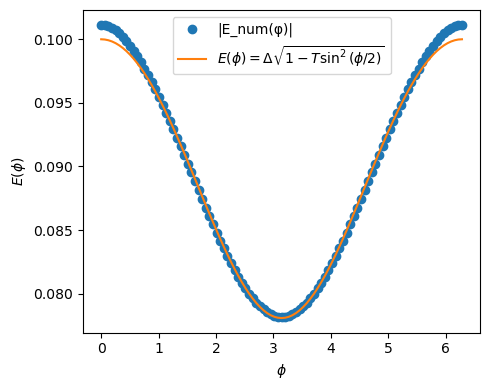

In [23]:
# Parámetros físicos
Delta = 0.1
t = 1.0
mu = 0.0
LS, LW, RS = 100, 1, 100   # junta corta
Vb = 2.5               # fuerza de la barrera (ajusta a gusto)
E_F = 0.0              # Fermi ~ 0 en este modelo (mu=0)

# 1) Transparencia normal T para este Vb
T_normal = transm(Vb, mu=mu, t=t, L=1, E=E_F)
print("T =", T_normal)

# 2) ABS numérico vs φ en el estado superconducting
phi_list = np.linspace(0, 2*np.pi, 101)
E_num = np.full_like(phi_list, np.nan, dtype=float)

#k_eigs = 12  # nº de autovalores alrededor de 0

for i, phi in enumerate(phi_list):
    syst_f = make_sns_1d(phi, LS=LS, LW=LW, RS=RS,
                         mu=mu, Delta=Delta, t=t,
                         Vb=Vb)

    H = syst_f.hamiltonian_submatrix(sparse=True)
    evals, evecs = sla.eigsh(H, k=k_eigs, sigma=0.0)
    evals = np.real(evals)

    # nivel más cercano a 0 en |E|
    evals_sorted = sorted(evals, key=lambda E: abs(E))
    E_closest = evals_sorted[0]
    E_num[i] = abs(E_closest)

# 3) Analytical expression
E_analytic_abs = Delta * np.sqrt(1.0 - T_normal * np.sin(phi_list / 2.0)**2)

# ------------ Plot comparación ------------
plt.figure(figsize=(5,4))
plt.plot(phi_list, E_num, 'o', label='|E_num(φ)|')
plt.plot(phi_list, E_analytic_abs, '-', label=r'$E(\phi) = \Delta\sqrt{1 - T\sin^2(\phi/2)}$')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$E(\phi)$')
##plt.title(f'SNS 1D corta con barrera Vb={Vb:.2f}, T≈{T_normal:.3f}')
##plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Symmetry Checking

Remember that when we defined `~kwant.builder.Builder` for the left lead above,
we not only declared an electron-hole conservation law, but also that the Hamiltonian
has the particle-hole symmetry :math:`\mathcal{P} = \sigma_y` which anticommutes
with the Hamiltonian, using the argument ``particle_hole``.
In Kwant, whenever one or more of the fundamental discrete symmetries
(time-reversal, particle-hole and chiral) are present in a lead Hamiltonian,
they can be declared in `~kwant.builder.Builder`. Kwant then automatically uses
them to construct scattering states that obey the specified symmetries. In this
example, we have a discrete symmetry declared in addition to a conservation law.
For any two conservation law blocks that are transformed to each other by the
discrete symmetry, Kwant then automatically computes the scattering states of one
block by applying the symmetry operator to the scattering states of the other.

Now, :math:`\mathcal{P}` relates electrons and holes
at *opposite* energies. However, a scattering problem is always solved at a
fixed energy, so generally :math:`\mathcal{P}` does not give a relation between
the electron and hole blocks. The exception is of course at zero energy, in which
case particle-hole symmetry transforms between the electron and hole blocks, resulting
in a symmetric scattering matrix. We can check the symmetry explicitly with

In [24]:
#### Cheking the symmetries 

def check_PHS(syst):
    # Scattering matrix
    s = kwant.smatrix(syst, energy=0)
    # Electron to electron block
    s_ee = s.submatrix((0,0), (0,0))
    # Hole to hole block
    s_hh = s.submatrix((0,1), (0,1))
    print('s_ee: \n', np.round(s_ee, 3))
    print('s_hh: \n', np.round(s_hh[::-1, ::-1], 3))
    print('s_hh: \n\ no order', np.round(s_hh, 3))
    print('s_ee - s_hh^*: \n',
          np.round(s_ee - s_hh[::-1, ::-1].conj(), 3), '\n')
    # Electron to hole block
    s_he = s.submatrix((0,1), (0,0))
    # Hole to electron block
    s_eh = s.submatrix((0,0), (0,1))
    print('s_he: \n', np.round(s_he, 3))
    print('s_eh: \n', np.round(s_eh[::-1, ::-1], 3))
    print('s_he + s_eh^*: \n',
          np.round(s_he + s_eh[::-1, ::-1].conj(), 3))
    
    
check_PHS(syst)

s_ee: 
 [[-0.121+0.114j -0.   -0.j   ]
 [ 0.   +0.j     0.481+0.008j]]
s_hh: 
 [[-0.121-0.114j -0.   +0.j   ]
 [ 0.   -0.j     0.481-0.008j]]
s_hh: 
\ no order [[ 0.481-0.008j  0.   -0.j   ]
 [-0.   +0.j    -0.121-0.114j]]
s_ee - s_hh^*: 
 [[-0.+0.j -0.+0.j]
 [-0.+0.j -0.-0.j]] 

s_he: 
 [[-0.+0.j    -0.-0.877j]
 [ 0.-0.986j  0.-0.j   ]]
s_eh: 
 [[-0.-0.j    -0.-0.877j]
 [ 0.-0.986j  0.+0.j   ]]
s_he + s_eh^*: 
 [[-0.+0.j -0.+0.j]
 [ 0.-0.j  0.-0.j]]


Note that $\mathcal{P}$ flips the sign of momentum, and for the parameters
we consider here, there are two electron and two hole modes active at zero energy.
We thus reorder the matrix elements of the scattering matrix blocks above,
to ensure that the same matrix elements in the electron and hole blocks relate
scattering states and their particle hole partners.

Please send corrections to <code>jalil@udel.edu</code>